# Predictor de precios de laptops

Estudiante: Ulises Zagare

Para la cursada de Matematica III en la UNSAM.

Dataset obtenido de: https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset

Datos del dataset scrapeados de: https://www.pccomponentes.com/

Este notebook usa un dataset para predecir el precio de una laptop, segun su CPU, GPU, cantidad de memoria RAM, cantidad de almacenamiento, tipo de almacenamiento, etc.

El dataset contiene la siguiente informacion:

- **Laptop**: Strings con toda la informacion de la laptop. No se utiliza.
- **Status**: Si la laptop esta nueva o usada.
- **Brand**: La marca de la laptop. Se usa para filtrar resultados.
- **Model**: El modelo de la laptop.
- **CPU**: Marca y modelo del procesador.
- **RAM**: Memoria RAM en gigabytes.
- **Storage**: El almacenamiento en gigabytes.
- **Storage Type**: El tipo de almacenamiento. No se utiliza.
- **GPU**: Modelo de la GPU.
- **Screen**: Tamaño de la pantalla en pulgadas.
- **Touch**: Si la pantalla tiene touch o no. No se utiliza.

In [1]:
#############################################################
# BLOQUE DE CONFIGURACION PARA CAMBIOS RAPIDOS EN EL CODIGO #
#############################################################
#
# Marca de la laptop a predecir. Si es "" no se filtrara por marca
MARCA_LAPTOP = "Apple"
#
# Que hacer con los outliers encontrados
# 0: No hacer nada
# 1: Remover outliers
# 2: Imputar outliers
REMOVER_OUTLIERS = -1

# Analisis y preprocesamiento

Primero que nada importamos todas las librerias que debemos usar.

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
%matplotlib inline

random.seed(a=None, version=2)

Y algunas funciones generales: 2 para detectar outliers usando IQR y Z-Score, una para remover las filas con outliers, uno para cambiar los valores de ls outliers por NaN, y otro para hacer el label encode.

In [3]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Definir límites para identificar valores atípicos
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Identificar valores atípicos
    valores_atipicos = df[(df[column] < limite_inferior) | (df[column] > limite_superior)]
    print("El valor del IRQ es: ", IQR)
    print("El valor del límite inferior es :", limite_inferior)
    print("El valor del límite superior es :", limite_superior)
    print("Valores Atípicos Detectados :")
    print(valores_atipicos[column])

    data = (IQR, limite_inferior, limite_superior)

    return valores_atipicos

def detect_outliers_zscore(df, column):
    # Calcular el Z-Score de los datos
    df['z_score'] = (df[column] - df[column].mean()) / df[column].std()
    # Identificar valores atípicos
    # Por ejemplo, los puntos de datos donde el Z-Score es mayor que 2 o menor que -2
    valores_atipicos = df[np.abs(df['z_score']) > 2]
    print("Valores Atípicos Detectados:",valores_atipicos)
    return valores_atipicos

def remove_outliers(df, df_outliers):
    df_outliers_index = df_outliers.index.tolist()
    return df.drop(index=df_outliers_index, errors="ignore")

def nan_outliers(df, df_outliers, columna):
    df_outliers_index = df_outliers.index.tolist()
    for i in df_outliers_index:
        df.at[i, columna] = np.nan
    return df

def label_encode_dummy(x, column):
    column_loc = column
    labelencoder = LabelEncoder()
    x[:,column] = labelencoder.fit_transform(x[:,column])
    
    return (x, labelencoder.classes_)


### Dataset
Cargamos el dataset, y cambiamos los valores booleanos por valores numericos 1 y 0, para poder ser procesados por el modelo (como si fuese LabelEncoder).

Tambien llena los nans de texto, ya que no pueden ser imputados como valores numericos. Los NaNs en Storage Type se cambian por SSD, y los de GPU por un "No".

Aca se elige filtrar por marca, ya que filtrando por marca los resultados pueden llegar a ser mas precisos. La marca se selecciona en el bloque de configuracion arriba.

In [4]:
df = pd.read_csv("laptops.csv")

if MARCA_LAPTOP != "":
    df = df[df['Brand'] == MARCA_LAPTOP]

df["Status"] = df["Status"].str.replace("New", "1.0")
df["Status"] = df["Status"].str.replace("Refurbished", "0.0")
df["Status"] = pd.to_numeric(df["Status"], errors="coerce")

df["Touch"] = df["Touch"].str.replace("Yes", "0.0")
df["Touch"] = df["Touch"].str.replace("No", "0.0")
df["Touch"] = pd.to_numeric(df["Touch"], errors="coerce")

#Llena los nans (de texto, los numericos se imputan)
df["Storage type"] = df["Storage type"].fillna("SSD")
df["GPU"] = df["GPU"].fillna("No")

df

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
50,Apple MacBook Air Apple M1/8GB/256GB SSD/GPU H...,1.0,Apple,MacBook Air,Apple M1,8,256,SSD,No,13.3,0.0,1219.00
69,Apple Macbook Pro Apple M2/8GB/256GB SSD/GPU D...,1.0,Apple,MacBook Pro,Apple M2,8,256,SSD,No,13.3,0.0,1599.00
130,Apple Macbook Air Apple M2/8GB/256GB SSD/GPU O...,1.0,Apple,MacBook Air,Apple M2,8,256,SSD,No,13.6,0.0,1519.00
155,Apple MacBook Air Apple M1/8GB/256GB SSD/GPU H...,1.0,Apple,MacBook Air,Apple M1,8,256,SSD,No,13.3,0.0,1219.00
162,Apple Macbook Air Apple M2/8GB/256GB SSD/GPU O...,1.0,Apple,MacBook Air,Apple M2,8,256,SSD,No,13.6,0.0,1519.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1766,Apple MacBook Pro Intel Core i9 2.3GHz/16GB/51...,0.0,Apple,MacBook Pro,Intel Core i9,16,512,SSD,Radeon Pro RX 560X,15.4,0.0,1410.65
1767,Apple MacBook Pro Intel Core i9 2.3GHz/16GB/51...,0.0,Apple,MacBook Pro,Intel Core i9,16,512,SSD,Radeon Pro RX 560X,15.4,0.0,1410.65
1768,Apple MacBook Pro Touch Bar Intel Core i7/16Gb...,0.0,Apple,MacBook Pro,Intel Core i7,16,1000,SSD,No,13.3,0.0,1632.50
1769,Apple Macbook Air Apple M2/8 GB/256GB SSD/GPU ...,0.0,Apple,MacBook Air,Apple M2,8,256,SSD,No,13.6,0.0,1519.00


Nos fijamos si hay nulls, y si hay nulls los imputa reemplazandolos por el promedio.

In [5]:
df.isnull().any()

Laptop          False
Status          False
Brand           False
Model           False
CPU             False
RAM             False
Storage         False
Storage type    False
GPU             False
Screen          False
Touch           False
Final Price     False
dtype: bool

In [6]:
#Screen tiene NaNs! Los imputa reemplazandolos por el promedio.

imputer = SimpleImputer(missing_values = np.nan, strategy="mean")
imputer = imputer.fit(df.iloc[:, 9:10])
df.iloc[:, 9:10] = imputer.transform(df.iloc[:, 9:10])

df.isnull().any()

Laptop          False
Status          False
Brand           False
Model           False
CPU             False
RAM             False
Storage         False
Storage type    False
GPU             False
Screen          False
Touch           False
Final Price     False
dtype: bool

### Matriz de correlacion y analisis de los datos
La matriz de correlacion es un grafico donde se muestra que tan correlacionados estan los valores del dataset, en este caso se usa para ver cuales son los valores que determinan el precio.

Varios de los valores a tomar en cuenta son categoricos y no se puede representar en una matriz de correlacion. Los que se pueden representar son la RAM, el almacenamiento, y el tamaño de la pantalla. El estado y el touch son booleanos convertidos a 0/1.

<Axes: >

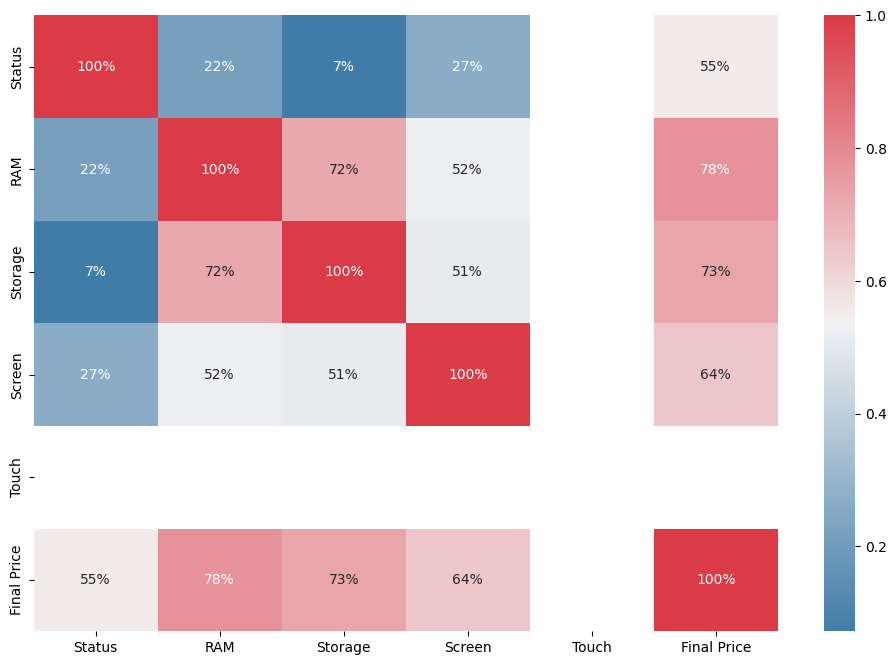

In [7]:
corr = df.corr(numeric_only = True)
plt.subplots(figsize=(12,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt='.0%',
cmap=sns.diverging_palette(240, 10, as_cmap=True))

In [8]:
corr['Final Price'].abs().sort_values(ascending=False)

Final Price    1.000000
RAM            0.775527
Storage        0.729894
Screen         0.642895
Status         0.550931
Touch               NaN
Name: Final Price, dtype: float64

En el grafico y la salida de correlaciones podemos ver que los valores numericos que mas afectan al precio son la memoria RAM y la capacidad de almacenamiento, mientras que el estado (nuevo/usado) y el touch de la pantalla no afecta el precio, asi que se descartan.

Vemos los datos estadisticos del dataset:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, 50 to 1770
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        116 non-null    object 
 1   Status        116 non-null    float64
 2   Brand         116 non-null    object 
 3   Model         116 non-null    object 
 4   CPU           116 non-null    object 
 5   RAM           116 non-null    int64  
 6   Storage       116 non-null    int64  
 7   Storage type  116 non-null    object 
 8   GPU           116 non-null    object 
 9   Screen        116 non-null    float64
 10  Touch         116 non-null    float64
 11  Final Price   116 non-null    float64
dtypes: float64(4), int64(2), object(6)
memory usage: 11.8+ KB


In [10]:
df.describe()

,Status,RAM,Storage,Screen,Touch,Final Price
count,116.000000,116.000000,116.000000,116.000000,116.0,116.000000
mean,0.405172,13.034483,508.620690,14.009483,0.0,1578.227672
std,0.493055,7.480910,350.544264,1.126825,0.0,857.160470
min,0.000000,4.000000,128.000000,12.000000,0.0,299.000000
25%,0.000000,8.000000,256.000000,13.300000,0.0,882.142500
50%,0.000000,8.000000,512.000000,13.300000,0.0,1491.330000
75%,1.000000,16.000000,512.000000,15.075000,0.0,1905.482500
max,1.000000,32.000000,2000.000000,16.200000,0.0,3849.000000


Podemos observar que el promedio del precio es de 1300 euros, la laptop mas barata es de 200 euros y la mas cara de 7000 euros.

## Outliers
Los outliers o valores atipicos pueden afectar drasticamente las predicciones del modelo. Por lo tanto se tratan de manejar de alguna forma. Generalmente o se los remueve completamente la fila, o se los reemplaza por otro valor, tipicamente la media o la mediana.

El usuario puede elegir en el bloque de configuracion si sacar los outliers o no, ya que los datos siendo extraidos de una pagina de venta de electrodomesticos, es muy poco probable que haya datos falsos.

Esto lo decidi asi porque veo que el modelo aumenta la precision si los outliers son dejados como estan.



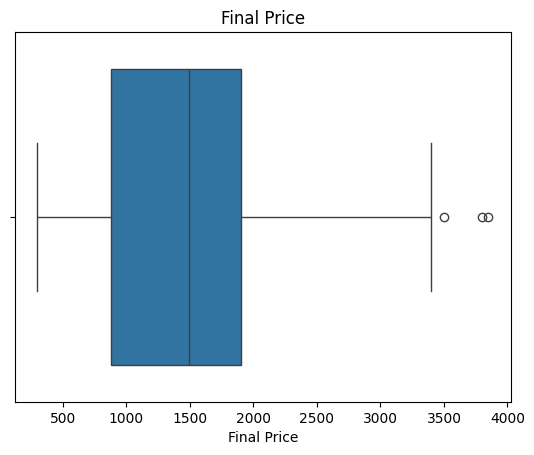

In [11]:
g = sns.boxplot(data = df, x = 'Final Price')

# Add a title and change xlabel
g.set_title('Final Price')
g.set_xlabel('Final Price')
plt.show()

In [12]:
remove_or_nan = REMOVER_OUTLIERS # -1: dont remove outliers; 0: remove; 1: nan
outliers = detect_outliers_iqr(df, "Final Price")
purge_outliers = True #Sacar todos los outliers o solo la primera pasada?

print(f"Detected {len(outliers)} outliers.")

if remove_or_nan != 0:
    if remove_or_nan == 1:
        while len(outliers != 0):
            print(f"Removed {len(outliers)} outliers.")
            df = remove_outliers(df, outliers)
            outliers = detect_outliers_iqr(df, "Final Price")

            if not purge_outliers:
                break
            
    if remove_or_nan == 2:
        df = nan_outliers(df, outliers, "Final Price")
        
        while len(outliers) != 0:
            df = nan_outliers(df, outliers, "Final Price")
            print(f"NaNed {len(outliers)} outliers.")
            imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
            imputer = imputer.fit(df.iloc[:,11:12])
            df.iloc[:, 11:12] = imputer.transform(df.iloc[:, 11:12])
            outliers = detect_outliers_iqr(df, "Final Price")

            if not purge_outliers:
                break
    
df

El valor del IRQ es:  1023.34
El valor del límite inferior es : -652.8675
El valor del límite superior es : 3440.4925000000003
Valores Atípicos Detectados :
416    3849.00
500    3799.00
583    3499.01
Name: Final Price, dtype: float64
Detected 3 outliers.


,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
50,Apple MacBook Air Apple M1/8GB/256GB SSD/GPU H...,1.0,Apple,MacBook Air,Apple M1,8,256,SSD,No,13.3,0.0,1219.00
69,Apple Macbook Pro Apple M2/8GB/256GB SSD/GPU D...,1.0,Apple,MacBook Pro,Apple M2,8,256,SSD,No,13.3,0.0,1599.00
130,Apple Macbook Air Apple M2/8GB/256GB SSD/GPU O...,1.0,Apple,MacBook Air,Apple M2,8,256,SSD,No,13.6,0.0,1519.00
155,Apple MacBook Air Apple M1/8GB/256GB SSD/GPU H...,1.0,Apple,MacBook Air,Apple M1,8,256,SSD,No,13.3,0.0,1219.00
162,Apple Macbook Air Apple M2/8GB/256GB SSD/GPU O...,1.0,Apple,MacBook Air,Apple M2,8,256,SSD,No,13.6,0.0,1519.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1766,Apple MacBook Pro Intel Core i9 2.3GHz/16GB/51...,0.0,Apple,MacBook Pro,Intel Core i9,16,512,SSD,Radeon Pro RX 560X,15.4,0.0,1410.65
1767,Apple MacBook Pro Intel Core i9 2.3GHz/16GB/51...,0.0,Apple,MacBook Pro,Intel Core i9,16,512,SSD,Radeon Pro RX 560X,15.4,0.0,1410.65
1768,Apple MacBook Pro Touch Bar Intel Core i7/16Gb...,0.0,Apple,MacBook Pro,Intel Core i7,16,1000,SSD,No,13.3,0.0,1632.50
1769,Apple Macbook Air Apple M2/8 GB/256GB SSD/GPU ...,0.0,Apple,MacBook Air,Apple M2,8,256,SSD,No,13.6,0.0,1519.00


# Prediccion

Para predecir los precios se programo un modelo basado en Regresion Lineal Multiple, el cual calcula una ecuacion lineal con varias incognitas, una por cada elemento que afecte el precio. Para calcular las pendientes se utiliza el metodo de los minimos cuadrados.

En esta seccion se eligen las columnas a usar como X, y luego se crean variables dummy para las variables caregoricas.

Se crean variables dummy para quitar el orden jerarquico que el modelo le aplicaria a las variables categoricas.

Se elige el Modelo, CPU, RAM, Almacenamiento, GPU y tamaño de pantalla como atributos o variables independientes o X. El estado, tipo de almacenamiento y touch se descartan por no influir demasiado. Brand se usa para filtrar resultados. El precio final se asigna como el valor dependiente o Y.

Tambien se obtienen listas con los modelos, gpus y cpus para el menu predictor del final.

In [13]:
Xcolumns = [
    'Model',
    'CPU', 
    'RAM', 
    'Storage', 
    'GPU',
    'Screen'
    ]

X = df[Xcolumns].values
y = df['Final Price'].values

X, lista_gpu = label_encode_dummy(X, Xcolumns.index('GPU')) #GPU
X, lista_cpu = label_encode_dummy(X, Xcolumns.index('CPU')) #CPU
X, lista_models = label_encode_dummy(X, Xcolumns.index('Model')) #Model

labeled_X = X

onehotencoder = make_column_transformer(
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('GPU')]), 
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('CPU')]), 
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('Model')]), 
    remainder = "passthrough")
X = onehotencoder.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#Escala los datos 
scaler_x = StandardScaler(with_mean=False)
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

#Finalmente crea la regresion y la entrena con los datos de entrenamiento
regression = LinearRegression()
regression.fit(X_train, y_train)

#Y ahora a testearlo con los datos de prueba
y_pred = regression.predict(X_test)

El modelo ya predijo los precios de los datos de prueba introducidos. Se pueden ver en la siguiente tabla:

In [15]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1.head(60)

,Actual,Predicted
0,3849.00,3022.981307
1,926.65,818.868911
2,1599.00,1754.017582
3,3279.00,3184.017686
4,3379.01,3137.965940
5,1599.00,1587.359271
6,1599.00,1754.017582
7,1020.01,895.854915
8,2999.01,2970.926069
9,710.00,747.380000


Podemos evaluar el rendimiento del modelo si usamos las metricas del error cuadratico medio, raiz cuadrada del error cuadratico medio, error medio absoluto, y R^2 o coeficiente de determinacion. R^2 es el mas facil de leer si el modelo fue preciso con los datos. Si se aproxima a 0 es que el modelo no es preciso, si se aproxima a 1 es que el modelo es preciso.

In [16]:
print('Error Medio Absoluto (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Error cuadrático medio (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Raíz cuadrada del error cuadrático medio (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2', metrics.r2_score(y_test, y_pred))
if  metrics.r2_score(y_test, y_pred) > 0.9:
    print("El R^2 indica que el modelo es bastante preciso")
elif  metrics.r2_score(y_test, y_pred) > 0.8:
    print("El R^2 indica que el modelo es aceptable")
elif  metrics.r2_score(y_test, y_pred) > 0.6:
    print("El R^2 indica que el modelo puede mejorar")
else:
    print("El R^2 indica que el modelo no esta siendo preciso")

Error Medio Absoluto (MAE): 173.2464246149486
Error cuadrático medio (MSE): 74086.51690501509
Raíz cuadrada del error cuadrático medio (RMSE): 272.1883849561092
R^2 0.9286525969135764
El R^2 indica que el modelo es bastante preciso


## Visualizacion de datos

Mientras esten mas juntos formando una linea, mejor estan. Eso quiere decir que las predicciones son mas precisas porque se parecen mas a los precios de verdad.

Si la marca elegida tiene muchas entradas, por ejemplo apple, las predicciones saldran mas precisas ya que el modelo tiene mas datos para poder afinarse.

Si la marca tiene muy pocas entradas es muy probable que el R^2 de muy malos resultados, ya que una menor cantidad de datos da a que los resultados sean menos precisos.

En el grafico inferior se comparan los precios de verdad y los precios que predijo el modelo.

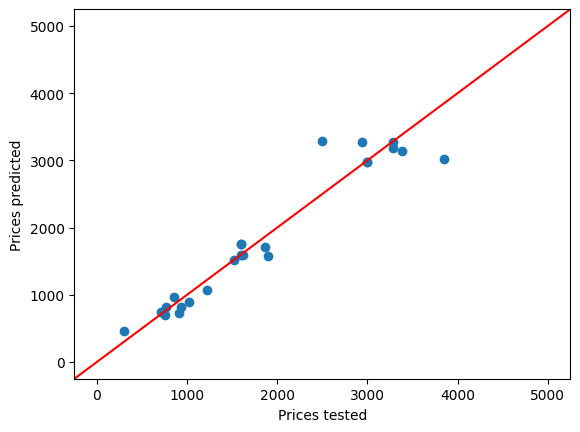

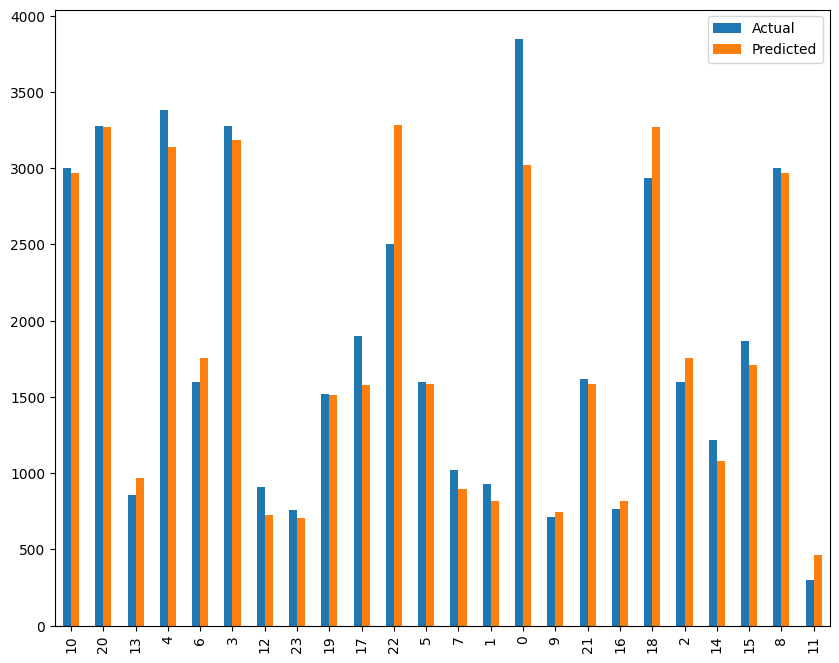

In [17]:
plt.scatter(y_test, y_pred)
plt.axline((0,0),(5000,5000), color="red")
plt.xlabel("Prices tested")
plt.ylabel("Prices predicted")
df1.sample(frac=1).head(50).plot(kind='bar',figsize=(10,8))
plt.show()

# Predictor de precios de Laptops

Es necesario instalar el modulo de `ipywidgets` para esta parte.

Podes probar el predictor con los controles que aparecen abajo. Se puede seleccionar el modelo, cpu, ram, almacenamiento, gpu y tamaño de pantalla. La marca se selecciona arriba en el bloque de configuracion del notebook, ya que el entrenamiento esta separado por marca (o no) para ser mas preciso.

In [20]:
@interact
def predict_laptop_price(
                      model=list(lista_models),
                      cpu=list(lista_cpu),
                      ram=(df["RAM"].min(), df["RAM"].max()),
                      storage=(df["Storage"].min(), df["Storage"].max()),
                      gpu=list(lista_gpu),
                      screen=(4,30,0.1),
                      ):
    #brand = list(lista_brands).index(brand)
    model = list(lista_models).index(model)
    cpu = list(lista_cpu).index(cpu)
    #storage_type=list(lista_storagetype).index(storage_type)
    gpu=list(lista_gpu).index(gpu)
    
    uX = np.array([
           float(model), 
           float(cpu), 
           float(ram), 
           float(storage), 
           float(gpu),
           float(screen)
                  ])

    pX = labeled_X
    
    pX = np.vstack((pX, uX))

    onehotencoder = make_column_transformer(
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('GPU')]), 
    #(OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('Storage type')]), 
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('CPU')]), 
    (OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('Model')]), 
    #(OneHotEncoder(drop="first", sparse_output=True), [Xcolumns.index('Brand')]), 
    remainder = "passthrough")
    
    pX = onehotencoder.fit_transform(pX)

    pX = scaler_x.transform(pX)
    
    pred = regression.predict(pX)
    print("Precio de la laptop calculado:", pred[-1])

interactive(children=(Dropdown(description='model', options=('MacBook Air', 'MacBook Pro', 'Macbook'), value='…